In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install geopandas folium plotly seaborn matplotlib pandas numpy -q
print("All required libraries have been installed.")

All required libraries have been installed.


In [ ]:
!unzip "/content/drive/My Drive/EST_Project/output_merged_csv.zip" -d "/content/data/"

Archive:  /content/drive/My Drive/EST_Project/output_merged_csv.zip
   creating: /content/data/output_merged_csv/
  inflating: /content/data/output_merged_csv/merged_output.csv  
  inflating: /content/data/output_merged_csv/merged_output_Dilshad.csv  
  inflating: /content/data/output_merged_csv/merged_output_isbt.csv  
  inflating: /content/data/output_merged_csv/merged_output_ito.csv  
  inflating: /content/data/output_merged_csv/merged_output_CPCBHQ.csv  
  inflating: /content/data/output_merged_csv/merged_output_mandir_marg.csv  
  inflating: /content/data/output_merged_csv/merged_output_nsit.csv  
  inflating: /content/data/output_merged_csv/merged_output_punjabi.csv  
  inflating: /content/data/output_merged_csv/merged_output_centralschool.csv  
  inflating: /content/data/output_merged_csv/merged_output_civil_lines.csv  


In [ ]:
# Cell 3 : Load, Merge, Clean, and Process Data
import pandas as pd
import numpy as np
import glob
import os

# --- 1. Load and Merge All 10 Station CSVs ---
data_folder_path = '/content/data/output_merged_csv/'
all_files = glob.glob(os.path.join(data_folder_path, "*.csv"))

df_list = []
print(f"Found {len(all_files)} station files. Merging now...")

for file in all_files:
    df = pd.read_csv(file)
    location_name = os.path.basename(file).replace('merged_output_', '').replace('.csv', '')
    df['Location'] = location_name
    df_list.append(df)

master_df = pd.concat(df_list, ignore_index=True)
print("All station data has been correctly merged.")

# --- 2. Perform Data Cleaning Checklist ---

# *** THIS IS THE CRITICAL FIX ***
# We will now only map the columns that we are certain exist in all files.
# The percentile columns (L10, L50, L90) have been removed.
column_mapping = {
    'Date/Time': 'DateTime',
    '4. LAF #1 Noise Level (Avg.)dBA': 'LAeq',
    '5. LAF #1 Noise Level (Max)dBA': 'Lmax',
    '6. LAF #1 Noise Level (Min)dBA': 'Lmin'
}
required_cols = list(column_mapping.keys()) + ['Location']

# Check which of the required columns actually exist in the master dataframe
# This makes the script robust even if column names vary slightly.
available_cols = [col for col in required_cols if col in master_df.columns]
df_cleaned = master_df[available_cols].rename(columns=column_mapping)

df_cleaned['DateTime'] = pd.to_datetime(df_cleaned['DateTime'])
df_cleaned.replace(0.0, np.nan, inplace=True)
df_cleaned.dropna(inplace=True)
df_cleaned.drop_duplicates(inplace=True)
df_cleaned.sort_values(by='DateTime', inplace=True)
print("Data cleaning is complete using available core columns.")

# --- 3. Calculate CPCB Compliance (without percentile-based metrics) ---

# Note: Noise Climate (NC) and Traffic Noise Index (TNI) cannot be calculated
# as they depend on the missing L10 and L90 columns. This is okay.

zone_mapping = {
    'nsit': 'Silence', 'centralschool': 'Silence', 'ito': 'Commercial',
    'isbt': 'Commercial', 'punjabi': 'Residential', 'mandir_marg': 'Residential',
    'civil_lines': 'Residential', 'CPCBHQ': 'Commercial', 'Dilshad': 'Residential'
}
df_cleaned['Zone_Type'] = df_cleaned['Location'].map(zone_mapping)

df_cleaned['Period'] = df_cleaned['DateTime'].dt.hour.apply(lambda x: 'Day' if 6 <= x < 22 else 'Night')

limits = {
    ('Commercial', 'Day'): 65, ('Commercial', 'Night'): 55,
    ('Residential', 'Day'): 55, ('Residential', 'Night'): 45,
    ('Silence', 'Day'): 50, ('Silence', 'Night'): 40,
    ('Industrial', 'Day'): 75, ('Industrial', 'Night'): 70
}
df_cleaned['CPCB_Standard'] = df_cleaned.apply(lambda row: limits.get((row['Zone_Type'], row['Period'])), axis=1)
df_cleaned['Compliance_Status'] = np.where(df_cleaned['LAeq'] > df_cleaned['CPCB_Standard'], 'Exceeds Limit', 'Within Limit')
print("CPCB compliance status calculated.")

# --- 4. Export Cleaned Dataset ---
# Adjusting the final columns to reflect the available data
final_columns = ['DateTime', 'Location', 'LAeq', 'Lmax', 'Lmin', 'Zone_Type', 'CPCB_Standard', 'Compliance_Status']
df_final = df_cleaned[final_columns]

output_path = '/content/drive/My Drive/EST_Project/Team_XX_CleanedData.csv'
df_final.to_csv(output_path, index=False)

print(f"\n✅ SUCCESS! Your cleaned data has been re-saved to: {output_path}")
print("\nHere is a preview of the final dataset:")
print(df_final.sample(10))

Found 10 station files. Merging now...
All station data has been correctly merged.
Data cleaning is complete using available core columns.
CPCB compliance status calculated.

✅ SUCCESS! Your cleaned data has been re-saved to: /content/drive/My Drive/EST_Project/Team_XX_CleanedData.csv

Here is a preview of the final dataset:
                   DateTime       Location       LAeq       Lmax       Lmin  \
1369631 2023-02-07 01:30:00  centralschool  56.260910  53.702419  42.354549   
2042711 2023-12-17 20:20:00         CPCBHQ  64.864761  78.841568  54.995251   
1984981 2022-11-10 20:50:00         CPCBHQ  66.855087  83.633087  50.847359   
763656  2023-07-26 18:30:00           isbt  69.235542  89.224426  59.854759   
1177079 2023-06-08 15:20:00           nsit  52.939800  67.680946  44.089230   
429620  2021-03-14 18:30:00    civil_lines  57.990799  69.972122  53.199501   
893283  2022-01-12 21:20:00        Dilshad  42.034550  37.501862  34.955101   
855618  2021-04-26 06:00:00        Dilsha

In [ ]:
# cell to verify the location coordinates
# ====================================================
# 🗺️ Delhi Coordinate Verification Script
# ====================================================

# Install dependencies
!pip install geopy folium --quiet

# --- Imports ---
from geopy.geocoders import Nominatim
import folium
import time

# --- Location data ---
location_coords = {
    'nsit': (28.609, 77.035),        # NSIT Dwarka
    'centralschool': (28.537, 77.252), # Kendriya Vidyalaya, Andrews Ganj (assumed)
    'ito': (28.631, 77.248),          # ITO Crossing
    'isbt': (28.667, 77.231),         # ISBT Anand Vihar
    'punjabi': (28.669, 77.125),      # Punjabi Bagh
    'mandir_marg': (28.628, 77.203),  # Mandir Marg
    'civil_lines': (28.678, 77.222),  # Civil Lines
    'CPCBHQ': (28.595, 77.252),       # CPCB HQ, East Arjun Nagar
    'Dilshad': (28.685, 77.318),      # Dilshad Garden
    'COE': (28.7433, 77.1169)         # College Of Engineering
}

# --- Initialize geolocator ---
geolocator = Nominatim(user_agent="geo_check_delhi")

# --- Reverse geocode all coordinates ---
print("🔍 Reverse Geocoding Results:\n")
results = {}

for name, (lat, lon) in location_coords.items():
    try:
        # Reverse geocode
        location = geolocator.reverse((lat, lon), language='en', timeout=10)
        address = location.address if location else "Not found"
        results[name] = address
        print(f"{name:15} -> {address}\n")
        time.sleep(1)  # Avoid hitting API rate limit
    except Exception as e:
        results[name] = f"Error: {e}"
        print(f"{name:15} -> Error: {e}\n")

# --- Plot all points on an interactive map ---
m = folium.Map(location=[28.61, 77.23], zoom_start=11, tiles='CartoDB positron')

for name, (lat, lon) in location_coords.items():
    addr = results.get(name, "No data")
    folium.Marker(
        [lat, lon],
        popup=f"<b>{name}</b><br>{addr}",
        tooltip=name,
        icon=folium.Icon(color='blue', icon='info-sign')
    ).add_to(m)

print("\n✅ Map generated below. You can zoom/pan to verify locations.")
m


🔍 Reverse Geocoding Results:

nsit            -> Netaji Subhas University of Technology, Azad Hind Fauj Marg, Sector 13, Dwarka, Dwarka Tehsil, South West Delhi, Delhi, 110078, India

centralschool   -> Chittaranjan Park, Kalkaji Tehsil, South East Delhi, Delhi, 110019, India

ito             -> Sachivalaya Road, Kotwali Tehsil, Central Delhi, Delhi, 110002, India

isbt            -> Kashmere Gate, Kotwali Tehsil, Central Delhi, Delhi, 110006, India

punjabi         -> Punjabi Bagh Tehsil, West Delhi, Delhi, 110026, India

mandir_marg     -> Kali Bari Lane, DIZ Area, Chanakya Puri Tehsil, New Delhi, Delhi, 110004, India

civil_lines     -> Under Hill Lane, Civil Lines, Civil Lines Tehsil, Central Delhi, Delhi, 110054, India

CPCBHQ          -> Humayun's Tomb Complex, Mathura Road, Defence Colony Tehsil, South East Delhi, Delhi, 110013, India

Dilshad         -> Dilshad Garden, Vivek Vihar Tehsil, Shahdara, Delhi, 110095, India

COE             -> Sector 17, Rohini, Alipur Tehsil, North

In [ ]:
# cell to generate the geojson
import pandas as pd
import geopandas as gpd

# --- 1. Load Your Cleaned Data ---
cleaned_data_path = '/content/drive/My Drive/EST_Project/Team_XX_CleanedData.csv'
df = pd.read_csv(cleaned_data_path)
print("Cleaned data loaded successfully.")

# --- 2. Get Station Coordinates ---
# IMPORTANT: Double-check these coordinates on Google Maps to ensure they are accurate.
location_coords = {
    'nsit': (28.609, 77.035),        # NSIT Dwarka
    'centralschool': (28.56, 77.23), # Kendriya Vidyalaya, Andrews Ganj (assumed)
    'ito': (28.631, 77.248),          # ITO Crossing
    'isbt': (28.646, 77.316),          # ISBT Anand Vihar
    'punjabi': (28.669, 77.125),      # Punjabi Bagh
    'mandir_marg': (28.628, 77.203),  # Mandir Marg
    'civil_lines': (28.678, 77.222),  # Civil Lines
    'CPCBHQ': (28.639, 77.303),      # CPCB Headquarter, East Arjun Nagar
    'Dilshad': (28.685, 77.318),       # Dilshad Garden
    'COE': (28.7433, 77.1169)         # College Of Engineering
}

# Add Latitude and Longitude columns to your DataFrame
df['latitude'] = df['Location'].map(lambda loc: location_coords.get(loc, (None, None))[0])
df['longitude'] = df['Location'].map(lambda loc: location_coords.get(loc, (None, None))[1])

# Drop any rows where coordinates might be missing
df.dropna(subset=['latitude', 'longitude'], inplace=True)
print("Coordinates have been added to the dataset.")

# --- 3. Create GeoJSON Layer ---
# Convert the pandas DataFrame to a GeoDataFrame
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df.longitude, df.latitude),
    crs='EPSG:4326' # This is the standard WGS 84 coordinate system for web maps
)

# NOTE: The DELHI_DISTRICTS.geojson file is for mapping later. Since your
# stations are points, we don't need to "clip" them, just save them.

# --- 4. Export the Spatial Layer ---
output_path = '/content/drive/My Drive/EST_Project/Team_XX_Noise_Stations.geojson'
gdf.to_file(output_path, driver='GeoJSON')

print(f"\n✅ SUCCESS! Your spatial layer has been created and saved to: {output_path}")
print("\nHere's a preview of your GeoDataFrame:")
print(gdf[['Location', 'LAeq', 'geometry']].head())

Cleaned data loaded successfully.
Coordinates have been added to the dataset.

✅ SUCCESS! Your spatial layer has been created and saved to: /content/drive/My Drive/EST_Project/Team_XX_Noise_Stations.geojson

Here's a preview of your GeoDataFrame:
      Location       LAeq                 geometry
0  mandir_marg  61.317249    POINT (77.203 28.628)
1         nsit  60.660351    POINT (77.035 28.609)
2          ito  76.784653    POINT (77.248 28.631)
3          COE  49.018131  POINT (77.1169 28.7433)
4  civil_lines  60.297241    POINT (77.222 28.678)


In [ ]:
# plotting graphs
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from google.colab import drive

drive.mount('/content/drive')

output_dir = '/content/drive/My Drive/EST_Project/Visualizations/'
os.makedirs(output_dir, exist_ok=True)

# Load data
df = pd.read_csv('/content/drive/My Drive/EST_Project/Team_XX_CleanedData.csv')
df['DateTime'] = pd.to_datetime(df['DateTime'])
gdf = gpd.read_file('/content/drive/My Drive/EST_Project/Team_XX_Noise_Stations.geojson')

print("✅ Datasets loaded successfully.\n")

# Set professional style
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 150

# ========== PLOT 1: Time-Series ==========
print("📊 Generating Plot 1: Time-Series...")
fig, ax = plt.subplots(figsize=(15, 6))
ito_data = df[df['Location'] == 'ito'].sort_values('DateTime')
ax.plot(ito_data['DateTime'], ito_data['LAeq'], linewidth=0.8, color='#e74c3c', alpha=0.8)
ax.set_xlabel('Date/Time', fontsize=13, fontweight='bold')
ax.set_ylabel('LAeq (dBA)', fontsize=13, fontweight='bold')
ax.set_title('Noise Levels Over Time at ITO Crossing', fontsize=16, fontweight='bold', pad=20)
ax.axhline(y=65, color='orange', linestyle='--', linewidth=2, label='Commercial Limit (65 dBA)', alpha=0.7)
ax.legend(loc='upper right', fontsize=11)
ax.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "01_timeseries_ito.png"), dpi=300, bbox_inches='tight')
plt.close()
print("✅ Saved: 01_timeseries_ito.png\n")

# ========== PLOT 2: Box Plot ==========
print("📊 Generating Plot 2: Comparative Box Plot...")
fig, ax = plt.subplots(figsize=(15, 7))
sns.boxplot(data=df, x='Location', y='LAeq', palette='Set2', ax=ax)
ax.axhline(y=65, color='orange', linestyle='--', linewidth=2, label='Commercial Limit', alpha=0.7)
ax.axhline(y=55, color='red', linestyle='--', linewidth=2, label='Residential Limit', alpha=0.7)
ax.axhline(y=50, color='darkred', linestyle='--', linewidth=2, label='Silence Zone Limit', alpha=0.7)
ax.set_xlabel('Monitoring Location', fontsize=13, fontweight='bold')
ax.set_ylabel('LAeq (dBA)', fontsize=13, fontweight='bold')
ax.set_title('Noise Level Distribution Across Delhi Locations', fontsize=16, fontweight='bold', pad=20)
ax.legend(loc='upper right', fontsize=10)
ax.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "02_comparative_boxplot.png"), dpi=300, bbox_inches='tight')
plt.close()
print("✅ Saved: 02_comparative_boxplot.png\n")

# ========== PLOT 3: Hotspot Map ==========
print("📊 Generating Plot 3: Noise Hotspot Map...")
avg_noise_map = gdf.groupby('Location').agg({
    'LAeq': 'mean',
    'geometry': 'first'
}).reset_index()
avg_noise_gdf = gpd.GeoDataFrame(avg_noise_map, geometry='geometry', crs="EPSG:4326")

fig, ax = plt.subplots(figsize=(14, 12))
avg_noise_gdf.plot(column='LAeq',
                   cmap='YlOrRd',
                   markersize=avg_noise_gdf['LAeq']*15,
                   legend=True,
                   legend_kwds={'label': "Average LAeq (dBA)", 'orientation': 'horizontal'},
                   edgecolor='black',
                   linewidth=1.5,
                   ax=ax)

# Add labels for each station
for idx, row in avg_noise_gdf.iterrows():
    ax.annotate(text=f"{row['Location']}\n{row['LAeq']:.1f} dBA",
                xy=(row.geometry.x, row.geometry.y),
                xytext=(5, 5), textcoords='offset points',
                fontsize=9, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))

ax.set_title('Noise Hotspots Across Delhi NCR (Average LAeq)',
             fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Longitude', fontsize=12, fontweight='bold')
ax.set_ylabel('Latitude', fontsize=12, fontweight='bold')
ax.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "03_hotspot_map.png"), dpi=300, bbox_inches='tight')
plt.close()
print("✅ Saved: 03_hotspot_map.png\n")

# ========== PLOT 4: Hourly Trends ==========
print("📊 Generating Plot 4: Hourly Noise Trends...")
df['hour'] = df['DateTime'].dt.hour
hourly_noise = df.groupby(['Location', 'hour'])['LAeq'].mean().reset_index()

fig, ax = plt.subplots(figsize=(16, 7))
for location in hourly_noise['Location'].unique():
    loc_data = hourly_noise[hourly_noise['Location'] == location]
    ax.plot(loc_data['hour'], loc_data['LAeq'],
            marker='o', label=location, linewidth=2.5, markersize=6, alpha=0.8)

ax.axvspan(0, 6, alpha=0.1, color='blue', label='Night (0-6 AM)')
ax.axvspan(22, 24, alpha=0.1, color='blue')
ax.set_xlabel('Hour of Day (0-23)', fontsize=13, fontweight='bold')
ax.set_ylabel('Average Noise (dBA)', fontsize=13, fontweight='bold')
ax.set_title('Average Noise Levels by Hour of the Day', fontsize=16, fontweight='bold', pad=20)
ax.set_xticks(range(0, 24))
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=10)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "04_hourly_noise_trends.png"), dpi=300, bbox_inches='tight')
plt.close()
print("✅ Saved: 04_hourly_noise_trends.png\n")

print("🎉 All 4 visualizations saved successfully to Google Drive!")
print(f"📁 Location: {output_dir}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Datasets loaded successfully.

📊 Generating Plot 1: Time-Series...
✅ Saved: 01_timeseries_ito.png

📊 Generating Plot 2: Comparative Box Plot...


/tmp/ipython-input-3429652389.py:44: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




✅ Saved: 02_comparative_boxplot.png

📊 Generating Plot 3: Noise Hotspot Map...
✅ Saved: 03_hotspot_map.png

📊 Generating Plot 4: Hourly Noise Trends...
✅ Saved: 04_hourly_noise_trends.png

🎉 All 4 visualizations saved successfully to Google Drive!
📁 Location: /content/drive/My Drive/EST_Project/Visualizations/


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from google.colab import drive

drive.mount('/content/drive')

output_dir = '/content/drive/My Drive/EST_Project/Visualizations/'
os.makedirs(output_dir, exist_ok=True)

# Load data
df = pd.read_csv('/content/drive/My Drive/EST_Project/Team_XX_CleanedData.csv')
df['DateTime'] = pd.to_datetime(df['DateTime'])

print("✅ Dataset loaded successfully.\n")
print(f"Available locations: {df['Location'].unique()}\n")

# Set professional style
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 150

# ========== OPTION 1: Individual Time-Series Plot for Each Location ==========
print("📊 Generating individual time-series plots for each location...\n")

locations = df['Location'].unique()

for location in locations:
    print(f"   → Processing: {location}")

    fig, ax = plt.subplots(figsize=(15, 6))
    location_data = df[df['Location'] == location].sort_values('DateTime')

    ax.plot(location_data['DateTime'], location_data['LAeq'],
            linewidth=0.8, color='#e74c3c', alpha=0.8)

    # Add CPCB standard lines
    ax.axhline(y=65, color='orange', linestyle='--', linewidth=2,
               label='Commercial Limit (65 dBA)', alpha=0.7)
    ax.axhline(y=55, color='red', linestyle='--', linewidth=2,
               label='Residential Limit (55 dBA)', alpha=0.7)

    # Special marking for NSIT (Silence Zone)
    if 'nsit' in location.lower():
        ax.axhline(y=50, color='darkred', linestyle='--', linewidth=2,
                   label='Silence Zone Limit (50 dBA)', alpha=0.7)

    ax.set_xlabel('Date/Time', fontsize=13, fontweight='bold')
    ax.set_ylabel('LAeq (dBA)', fontsize=13, fontweight='bold')
    ax.set_title(f'Noise Levels Over Time at {location.upper()}',
                 fontsize=16, fontweight='bold', pad=20)
    ax.legend(loc='upper right', fontsize=11)
    ax.grid(alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Save with location-specific filename
    filename = f"timeseries_{location.replace(' ', '_').lower()}.png"
    plt.savefig(os.path.join(output_dir, filename), dpi=300, bbox_inches='tight')
    plt.close()

print("\n✅ All individual time-series plots saved!\n")

# ========== OPTION 2: Combined Time-Series Plot (All Locations) ==========
print("📊 Generating combined time-series plot with all locations...\n")

fig, ax = plt.subplots(figsize=(18, 8))

colors = plt.cm.tab10(range(len(locations)))

for i, location in enumerate(locations):
    location_data = df[df['Location'] == location].sort_values('DateTime')
    ax.plot(location_data['DateTime'], location_data['LAeq'],
            linewidth=1.5, alpha=0.7, label=location.upper(), color=colors[i])

# Add CPCB standards
ax.axhline(y=65, color='orange', linestyle='--', linewidth=2.5,
           label='Commercial Limit (65 dBA)', alpha=0.8)
ax.axhline(y=55, color='red', linestyle='--', linewidth=2.5,
           label='Residential Limit (55 dBA)', alpha=0.8)
ax.axhline(y=50, color='darkred', linestyle='--', linewidth=2.5,
           label='Silence Zone Limit (50 dBA)', alpha=0.8)

ax.set_xlabel('Date/Time', fontsize=14, fontweight='bold')
ax.set_ylabel('LAeq (dBA)', fontsize=14, fontweight='bold')
ax.set_title('Noise Levels Over Time - All Delhi NCR Monitoring Stations',
             fontsize=18, fontweight='bold', pad=20)
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=10, framealpha=0.9)
ax.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "timeseries_all_locations_combined.png"),
            dpi=300, bbox_inches='tight')
plt.close()

print("✅ Combined time-series plot saved!\n")

# ========== OPTION 3: Faceted Time-Series (Subplots Grid) ==========
print("📊 Generating faceted time-series plot (grid of subplots)...\n")

n_locations = len(locations)
n_cols = 3
n_rows = (n_locations + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows), sharex=True, sharey=True)
axes = axes.flatten()

for i, location in enumerate(locations):
    location_data = df[df['Location'] == location].sort_values('DateTime')

    axes[i].plot(location_data['DateTime'], location_data['LAeq'],
                 linewidth=1, color='#3498db', alpha=0.8)
    axes[i].axhline(y=65, color='orange', linestyle='--', linewidth=1.5, alpha=0.6)
    axes[i].axhline(y=55, color='red', linestyle='--', linewidth=1.5, alpha=0.6)

    if 'nsit' in location.lower():
        axes[i].axhline(y=50, color='darkred', linestyle='--', linewidth=1.5, alpha=0.6)

    axes[i].set_title(location.upper(), fontsize=13, fontweight='bold')
    axes[i].grid(alpha=0.3)
    axes[i].tick_params(axis='x', rotation=45, labelsize=9)

# Remove empty subplots if any
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

fig.text(0.5, 0.02, 'Date/Time', ha='center', fontsize=14, fontweight='bold')
fig.text(0.02, 0.5, 'LAeq (dBA)', va='center', rotation='vertical',
         fontsize=14, fontweight='bold')
fig.suptitle('Noise Levels Over Time - All Monitoring Stations (Faceted View)',
             fontsize=18, fontweight='bold', y=0.995)

plt.tight_layout(rect=[0.03, 0.03, 1, 0.99])
plt.savefig(os.path.join(output_dir, "timeseries_all_locations_faceted.png"),
            dpi=300, bbox_inches='tight')
plt.close()

print("✅ Faceted time-series plot saved!\n")

# ========== Summary ==========
print("=" * 60)
print("🎉 TIME-SERIES VISUALIZATION COMPLETE!")
print("=" * 60)
print(f"\n📁 All files saved to: {output_dir}\n")
print("Generated files:")
print(f"  • {len(locations)} individual location plots (timeseries_<location>.png)")
print("  • 1 combined plot (timeseries_all_locations_combined.png)")
print("  • 1 faceted grid plot (timeseries_all_locations_faceted.png)")
print(f"\n📊 Total plots generated: {len(locations) + 2}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Dataset loaded successfully.

Available locations: ['mandir_marg' 'nsit' 'ito' 'COE' 'civil_lines' 'centralschool' 'punjabi'
 'isbt' 'CPCBHQ' 'Dilshad']

📊 Generating individual time-series plots for each location...

   → Processing: mandir_marg
   → Processing: nsit
   → Processing: ito
   → Processing: COE
   → Processing: civil_lines
   → Processing: centralschool
   → Processing: punjabi
   → Processing: isbt
   → Processing: CPCBHQ
   → Processing: Dilshad

✅ All individual time-series plots saved!

📊 Generating combined time-series plot with all locations...

✅ Combined time-series plot saved!

📊 Generating faceted time-series plot (grid of subplots)...

✅ Faceted time-series plot saved!

🎉 TIME-SERIES VISUALIZATION COMPLETE!

📁 All files saved to: /content/drive/My Drive/EST_Project/Visualizations/

Generated files:
  • 10 individual location plots 

In [ ]:
# ========== BONUS: Monthly Aggregated Time-Series ==========
print("📊 Generating monthly aggregated time-series...\n")

df['YearMonth'] = df['DateTime'].dt.to_period('M').dt.to_timestamp()
monthly_avg = df.groupby(['Location', 'YearMonth'])['LAeq'].mean().reset_index()

fig, ax = plt.subplots(figsize=(16, 8))

for location in locations:
    location_data = monthly_avg[monthly_avg['Location'] == location]
    ax.plot(location_data['YearMonth'], location_data['LAeq'],
            marker='o', linewidth=2.5, markersize=8, alpha=0.8, label=location.upper())

ax.axhline(y=65, color='orange', linestyle='--', linewidth=2, alpha=0.7, label='Commercial Limit')
ax.axhline(y=55, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Residential Limit')
ax.axhline(y=50, color='darkred', linestyle='--', linewidth=2, alpha=0.7, label='Silence Zone Limit')

ax.set_xlabel('Month', fontsize=14, fontweight='bold')
ax.set_ylabel('Average LAeq (dBA)', fontsize=14, fontweight='bold')
ax.set_title('Monthly Average Noise Levels - All Stations', fontsize=18, fontweight='bold', pad=20)
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=11)
ax.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "timeseries_monthly_averages.png"), dpi=300, bbox_inches='tight')
plt.close()

print("✅ Monthly aggregated plot saved!\n")

📊 Generating monthly aggregated time-series...

✅ Monthly aggregated plot saved!



In [ ]:
import pandas as pd
import os

# --- 1. Setup and Data Loading ---
# Create a dedicated folder for your tables
output_dir_tables = '/content/drive/My Drive/EST_Project/Tables/'
os.makedirs(output_dir_tables, exist_ok=True)

# Load your cleaned data
df = pd.read_csv('/content/drive/My Drive/EST_Project/Team_XX_CleanedData.csv')
df['DateTime'] = pd.to_datetime(df['DateTime'])

print("✅ Dataset loaded successfully.")

# --- 2. Generate Key Indicator Tables ---

# TABLE 1: Station Rankings by Average Noise Level
print("\n📊 Generating Table 1: Station Rankings...")
station_rankings = df.groupby('Location')['LAeq'].mean().sort_values(ascending=False).reset_index()
station_rankings.rename(columns={'LAeq': 'Average_LAeq_dBA'}, inplace=True)

# Save the table to a CSV file
station_rankings.to_csv(os.path.join(output_dir_tables, "01_station_rankings.csv"), index=False)

print("... saved successfully.")
print("--- STATION RANKINGS (Loudest to Quietest) ---")
print(station_rankings)
print("-" * 50)


# TABLE 2: Exceedance Summary (% of time violating CPCB standards)
print("\n📊 Generating Table 2: Exceedance Summary...")
df['Period'] = df['DateTime'].dt.hour.apply(lambda x: 'Day' if 6 <= x < 22 else 'Night')

# Calculate the percentage of time each station exceeds the limit, separated by Day/Night
exceedance_summary = df.groupby(['Location', 'Zone_Type', 'Period'])['Compliance_Status'].apply(
    lambda x: (x == 'Exceeds Limit').sum() / len(x) * 100
).reset_index(name='Percent_Time_Exceeding_Limit')

# Pivot the table for easier reading
exceedance_pivot = exceedance_summary.pivot_table(
    index=['Location', 'Zone_Type'],
    columns='Period',
    values='Percent_Time_Exceeding_Limit'
).fillna(0).reset_index()

# Save the table to a CSV file
exceedance_pivot.to_csv(os.path.join(output_dir_tables, "02_exceedance_summary.csv"), index=False)

print("... saved successfully.")
print("--- EXCEEDANCE SUMMARY (% Time Over Limit) ---")
print(exceedance_pivot)
print("-" * 50)


# TABLE 3: Hourly Statistics to Identify Peak Noise Hours
print("\n📊 Generating Table 3: Hourly Statistics...")
df['hour'] = df['DateTime'].dt.hour
hourly_stats = df.groupby('hour')['LAeq'].mean().reset_index()
hourly_stats.rename(columns={'LAeq': 'Average_LAeq_dBA'}, inplace=True)

# Save the table to a CSV file
hourly_stats.to_csv(os.path.join(output_dir_tables, "03_hourly_statistics.csv"), index=False)

print("... saved successfully.")
print("--- HOURLY STATISTICS (Peak Hours) ---")
print(hourly_stats.sort_values(by='Average_LAeq_dBA', ascending=False).head())
print("-" * 50)

print(f"\n✅ All summary tables have been generated and saved to: {output_dir_tables}")

✅ Dataset loaded successfully.

📊 Generating Table 1: Station Rankings...
... saved successfully.
--- STATION RANKINGS (Loudest to Quietest) ---
        Location  Average_LAeq_dBA
0            ito         70.606439
1           isbt         65.612747
2         CPCBHQ         61.040239
3    civil_lines         59.110068
4  centralschool         57.275597
5        punjabi         56.200350
6    mandir_marg         55.543972
7            COE         55.020388
8           nsit         54.286421
9        Dilshad         52.439642
--------------------------------------------------

📊 Generating Table 2: Exceedance Summary...
... saved successfully.
--- EXCEEDANCE SUMMARY (% Time Over Limit) ---
Period       Location    Zone_Type        Day      Night
0              CPCBHQ   Commercial  39.377516  47.010587
1             Dilshad  Residential  43.422312  73.224559
2       centralschool      Silence  95.298405  98.844524
3         civil_lines  Residential  93.726585  97.813472
4                i

In [ ]:
# --- 1. Setup and Installation ---
!pip install -U kaleido -q
!pip install scipy -q
# Install Chrome for kaleido
!plotly_get_chrome -y

import pandas as pd
import geopandas as gpd
import plotly.express as px
import numpy as np
from scipy.interpolate import griddata
import os

print("✅ Setup complete. All libraries are ready.")

# --- 2. Define Directories and Load Data ---
output_dir = '/content/drive/My Drive/EST_Project/Visualizations/'
os.makedirs(output_dir, exist_ok=True)
table_output_dir = '/content/drive/My Drive/EST_Project/Tables/'
os.makedirs(table_output_dir, exist_ok=True)

df = pd.read_csv('/content/drive/My Drive/EST_Project/Team_XX_CleanedData.csv')
df['DateTime'] = pd.to_datetime(df['DateTime'])
stations_gdf = gpd.read_file('/content/drive/My Drive/EST_Project/Team_XX_Noise_Stations.geojson')
delhi_districts_gdf = gpd.read_file('/content/drive/My Drive/EST_Project/DELHI_DISTRICTS.geojson')

print("✅ Datasets loaded successfully.")

# --- 3. DIAGNOSE & FIX: Find the correct district column name ---
# Let's inspect the columns of the districts GeoJSON file
print("\nInspecting the Delhi Districts GeoJSON file...")
print(f"Columns found: {delhi_districts_gdf.columns.tolist()}")

# Based on common GeoJSON formats, the column is likely 'DISTRICT' or 'NAME_2' or similar.
# We will programmatically find the correct column name.
# Let's assume the district column is the first one that isn't 'geometry'.
# You can manually change this if needed.
try:
    # Let's assume the column is named 'DISTRICT' and if not, we find it.
    district_col_name = 'DISTRICT'
    if district_col_name not in delhi_districts_gdf.columns:
        # A common alternative name is 'NAME_2'. Let's check for that.
        if 'NAME_2' in delhi_districts_gdf.columns:
            district_col_name = 'NAME_2'
        else:
            # As a last resort, use the first non-geometry column
            district_col_name = delhi_districts_gdf.columns[delhi_districts_gdf.columns != 'geometry'][0]

    print(f"✅ Automatically detected district column name as: '{district_col_name}'")
except IndexError:
    print("❌ Could not automatically determine the district column name. Please inspect the columns above and set it manually.")
    district_col_name = None # Set to None to prevent further errors


# --- 4. Generate and Save Advanced Maps (if district column was found) ---
if district_col_name:
    # ==============================================================================
    # MAP 1: Exceedance Map (Choropleth by District)
    # ==============================================================================
    print("\n🗺️ Generating Map 1: Exceedance Choropleth Map...")

    exceedance_summary = df.groupby('Location')['Compliance_Status'].apply(
        lambda x: (x == 'Exceeds Limit').sum() / len(x) * 100
    ).reset_index(name='Percent_Exceeding')
    unique_stations = stations_gdf.drop_duplicates(subset='Location')
    exceedance_gdf = pd.merge(unique_stations[['Location', 'geometry']], exceedance_summary, on='Location')
    stations_in_districts = gpd.sjoin(exceedance_gdf, delhi_districts_gdf, how="inner", predicate='within')

    # *** THIS IS THE FIX ***
    # Using the detected column name instead of the hardcoded 'DISTRICT'
    district_exceedance = stations_in_districts.groupby(district_col_name)['Percent_Exceeding'].mean().reset_index()
    districts_to_plot = pd.merge(delhi_districts_gdf, district_exceedance, on=district_col_name)

    fig_exceedance = px.choropleth_mapbox(
        districts_to_plot,
        geojson=districts_to_plot.geometry,
        locations=districts_to_plot.index,
        color="Percent_Exceeding",
        mapbox_style="carto-positron",
        center={"lat": 28.65, "lon": 77.23},
        zoom=8.5,
        hover_name=district_col_name,
        color_continuous_scale="Viridis",
        title="Choropleth Map of Noise Limit Exceedance by District"
    )
    fig_exceedance.update_geos(fitbounds="locations", visible=False)
    fig_exceedance.write_image(os.path.join(output_dir, "05_exceedance_choropleth_map.png"))
    print("... saved successfully.")


    # ==============================================================================
    # MAP 2: Zone Compliance / Violation Severity Map
    # ==============================================================================
    print("\n🗺️ Generating Map 2: Violation Severity Map...")

    exceeding_df = df[df['Compliance_Status'] == 'Exceeds Limit'].copy()
    exceeding_df['Violation_Severity_dBA'] = exceeding_df['LAeq'] - exceeding_df['CPCB_Standard']
    severity_summary = exceeding_df.groupby('Location')['Violation_Severity_dBA'].mean().reset_index()
    severity_gdf = pd.merge(unique_stations[['Location', 'geometry']], severity_summary, on='Location')
    severity_gdf.to_csv(os.path.join(table_output_dir, "04_violation_severity.csv"), index=False)

    fig_severity = px.scatter_mapbox(
        severity_gdf,
        lat=severity_gdf.geometry.y,
        lon=severity_gdf.geometry.x,
        size='Violation_Severity_dBA', color='Violation_Severity_dBA',
        hover_name='Location', color_continuous_scale=px.colors.sequential.Plasma,
        mapbox_style="open-street-map", zoom=8.5, center={"lat": 28.65, "lon": 77.23},
        title="Map of Noise Violation Severity by Station (Avg. dBA over limit)"
    )
    fig_severity.write_image(os.path.join(output_dir, "06_violation_severity_map.png"))
    print("... saved successfully.")


    # ==============================================================================
    # MAP 3: Interpolation Map (Noise Surface using IDW)
    # ==============================================================================
    print("\n🗺️ Generating Map 3: Interpolated Noise Surface Map...")

    avg_noise_stations = stations_gdf.groupby('Location').agg(
        LAeq_avg=('LAeq', 'mean'), geometry=('geometry', 'first')
    ).reset_index()

    points = np.array([avg_noise_stations.geometry.x, avg_noise_stations.geometry.y]).T
    values = avg_noise_stations['LAeq_avg'].values

    min_lon, min_lat, max_lon, max_lat = delhi_districts_gdf.total_bounds
    grid_x, grid_y = np.mgrid[min_lon:max_lon:100j, min_lat:max_lat:100j]
    grid_z = griddata(points, values, (grid_x, grid_y), method='cubic')

    interpolated_df = pd.DataFrame({
        'lon': grid_x.ravel(), 'lat': grid_y.ravel(), 'noise_level': grid_z.ravel()
    }).dropna()

    fig_interp = px.density_mapbox(
        interpolated_df, lat='lat', lon='lon', z='noise_level',
        radius=20, mapbox_style="stamen-terrain",
        center={"lat": 28.65, "lon": 77.23}, zoom=8.5,
        title="Interpolated Noise Surface Map Across Delhi NCR"
    )
    fig_interp.write_image(os.path.join(output_dir, "07_spatial_interpolation_map.png"))
    print("... saved successfully.")

    print("\n\n✅ All advanced spatial visualizations have been generated and saved!")

Installing Chrome for Plotly...
Chrome installed successfully.
The Chrome executable is now located at: /usr/local/lib/python3.12/dist-packages/choreographer/cli/browser_exe/chrome-linux64/chrome
✅ Setup complete. All libraries are ready.
✅ Datasets loaded successfully.

Inspecting the Delhi Districts GeoJSON file...
Columns found: ['dtname', 'stname', 'stcode11', 'dtcode11', 'year_stat', 'Shape_Length', 'Shape_Area', 'OBJECTID', 'test', 'Dist_LGD', 'State_LGD', 'geometry']
✅ Automatically detected district column name as: 'dtname'

🗺️ Generating Map 1: Exceedance Choropleth Map...


/tmp/ipython-input-1026273880.py:74: DeprecationWarning:

*choropleth_mapbox* is deprecated! Use *choropleth_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/



... saved successfully.

🗺️ Generating Map 2: Violation Severity Map...


/tmp/ipython-input-1026273880.py:102: DeprecationWarning:

*scatter_mapbox* is deprecated! Use *scatter_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/



... saved successfully.

🗺️ Generating Map 3: Interpolated Noise Surface Map...


AttributeError: 'Series' object has no attribute 'x'

In [ ]:
# ==============================================================================
# MAP 3: Interpolation Map (Noise Surface using IDW) - CORRECTED
# ==============================================================================
print("\n🗺️ Generating Map 3: Interpolated Noise Surface Map...")

# Aggregate data to get the average noise per station
avg_noise_stations_df = stations_gdf.groupby('Location').agg(
    LAeq_avg=('LAeq', 'mean'),
    geometry=('geometry', 'first')
).reset_index()

# *** THIS IS THE FIX ***
# Convert the aggregated DataFrame back into a GeoDataFrame
avg_noise_stations_gdf = gpd.GeoDataFrame(
    avg_noise_stations_df,
    geometry='geometry',
    crs="EPSG:4326"
)

# Now we can correctly access the .x and .y attributes
points = np.array([avg_noise_stations_gdf.geometry.x, avg_noise_stations_gdf.geometry.y]).T
values = avg_noise_stations_gdf['LAeq_avg'].values

# Create a grid of points to interpolate onto
min_lon, min_lat, max_lon, max_lat = delhi_districts_gdf.total_bounds
grid_x, grid_y = np.mgrid[min_lon:max_lon:100j, min_lat:max_lat:100j]

# Perform interpolation
grid_z = griddata(points, values, (grid_x, grid_y), method='cubic')

# Format the results for plotting
interpolated_df = pd.DataFrame({
    'lon': grid_x.ravel(),
    'lat': grid_y.ravel(),
    'noise_level': grid_z.ravel()
}).dropna()

# Create the density map
fig_interp = px.density_mapbox(
    interpolated_df,
    lat='lat',
    lon='lon',
    z='noise_level',
    radius=20,
    mapbox_style="open-street-map",
    center={"lat": 28.65, "lon": 77.23},
    zoom=8.5,
    title="Interpolated Noise Surface Map Across Delhi NCR"
)
fig_interp.write_image(os.path.join(output_dir, "07_spatial_interpolation_map.png"))
print("... saved successfully.")

print("\n\n✅ All advanced spatial visualizations have now been generated and saved!")


🗺️ Generating Map 3: Interpolated Noise Surface Map...


/tmp/ipython-input-838525621.py:39: DeprecationWarning:

*density_mapbox* is deprecated! Use *density_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/



... saved successfully.


✅ All advanced spatial visualizations have now been generated and saved!


In [ ]:
# --- 1. Setup and Installation ---
# Install the correct h3 library
!pip install h3 folium -q
print("✅ Installation complete.")

import pandas as pd
import geopandas as gpd
import numpy as np
from scipy.interpolate import griddata
import h3
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import os
from shapely.geometry import Polygon

print("✅ Setup complete.")

# --- 2. Load Data ---
output_dir = '/content/drive/My Drive/EST_Project/Visualizations/'
stations_gdf = gpd.read_file('/content/drive/My Drive/EST_Project/Team_XX_Noise_Stations.geojson')
delhi_districts_gdf = gpd.read_file('/content/drive/My Drive/EST_Project/DELHI_DISTRICTS.geojson')
print("✅ Datasets loaded.")

# --- 3. Perform Interpolation ---
avg_noise_stations_gdf = stations_gdf.groupby('Location').agg(
    LAeq_avg=('LAeq', 'mean'),
    geometry=('geometry', 'first')
).reset_index()
avg_noise_stations_gdf = gpd.GeoDataFrame(avg_noise_stations_gdf, geometry='geometry', crs="EPSG:4326")

points = np.array([avg_noise_stations_gdf.geometry.x, avg_noise_stations_gdf.geometry.y]).T
values = avg_noise_stations_gdf['LAeq_avg'].values

min_lon, min_lat, max_lon, max_lat = delhi_districts_gdf.total_bounds
grid_x, grid_y = np.mgrid[min_lon:max_lon:100j, min_lat:max_lat:100j]
grid_z = griddata(points, values, (grid_x, grid_y), method='cubic')

interpolated_df = pd.DataFrame({
    'lon': grid_x.ravel(),
    'lat': grid_y.ravel(),
    'noise_level': grid_z.ravel()
}).dropna()

print("✅ Interpolation complete.")

# --- 4. Create the Hexbin Grid ---
print("🔨 Creating hexbin grid...")

# Function to convert lat/lon to h3 hexagon
def lat_lon_to_h3(lat, lon, resolution=8):
    return h3.latlng_to_cell(lat, lon, resolution)

# Function to get hexagon boundary as polygon
def h3_to_polygon(hex_id):
    boundary = h3.cell_to_boundary(hex_id)
    # h3 returns (lat, lon), we need (lon, lat) for shapely
    return Polygon([(lon, lat) for lat, lon in boundary])

# Convert each interpolated point to a hexagon ID
resolution = 8  # Adjust: 7 = larger hexagons, 9 = smaller hexagons
interpolated_df['h3_id'] = interpolated_df.apply(
    lambda row: lat_lon_to_h3(row['lat'], row['lon'], resolution),
    axis=1
)

# Calculate average noise level per hexagon
hex_noise_avg = interpolated_df.groupby('h3_id')['noise_level'].mean().reset_index()

# Create polygon geometries for each hexagon
hex_noise_avg['geometry'] = hex_noise_avg['h3_id'].apply(h3_to_polygon)

# Convert to GeoDataFrame
hex_noise_gdf = gpd.GeoDataFrame(hex_noise_avg, geometry='geometry', crs="EPSG:4326")

print(f"✅ Hexbin grid created with {len(hex_noise_gdf)} hexagons.")

# --- 5. Plot the Hexbin Map with Plotly ---
print("📊 Generating Plotly hexbin map...")

fig_hex = px.choropleth_mapbox(
    hex_noise_gdf,
    geojson=hex_noise_gdf.geometry.__geo_interface__,
    locations=hex_noise_gdf.index,
    color="noise_level",
    mapbox_style="carto-positron",
    center={"lat": 28.65, "lon": 77.23},
    zoom=9,
    opacity=0.6,
    color_continuous_scale="RdYlGn_r",  # Red (high) to Green (low)
    labels={'noise_level': 'LAeq (dBA)'},
    title="Hexbin Interpolated Noise Surface Map - Delhi NCR"
)

fig_hex.update_layout(
    height=800,
    margin={"r":0,"t":40,"l":0,"b":0}
)

# Try to save (will work if kaleido is installed)
try:
    fig_hex.write_image(os.path.join(output_dir, "08_hexbin_interpolation_map.png"),
                       width=1400, height=1000, scale=2)
    print("✅ Hexbin map saved as PNG")
except Exception as e:
    print(f"⚠️ Could not save PNG: {e}")
    print("Saving as HTML instead...")
    fig_hex.write_html(os.path.join(output_dir, "08_hexbin_interpolation_map.html"))
    print("✅ Hexbin map saved as HTML")

fig_hex.show()

# --- 6. Alternative: Matplotlib Version (Always Works) ---
print("\n📊 Generating Matplotlib hexbin map...")

fig, ax = plt.subplots(figsize=(16, 14))

# Plot Delhi boundary
delhi_districts_gdf.boundary.plot(ax=ax, color='black', linewidth=1.5, alpha=0.7)

# Plot hexagons with color based on noise level
hex_noise_gdf.plot(column='noise_level',
                   cmap='RdYlGn_r',
                   edgecolor='gray',
                   linewidth=0.3,
                   legend=True,
                   legend_kwds={'label': "LAeq (dBA)", 'orientation': 'horizontal'},
                   alpha=0.75,
                   ax=ax)

# Add monitoring stations
avg_noise_stations_gdf.plot(ax=ax,
                            color='navy',
                            markersize=200,
                            edgecolor='white',
                            linewidth=2,
                            marker='o',
                            zorder=5,
                            label='Monitoring Stations')

# Add station labels
for idx, row in avg_noise_stations_gdf.iterrows():
    ax.annotate(f"{row['Location']}\n{row['LAeq_avg']:.1f} dBA",
                xy=(row.geometry.x, row.geometry.y),
                xytext=(8, 8), textcoords='offset points',
                fontsize=9, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.4', facecolor='white', alpha=0.8))

ax.set_title('Hexbin Interpolated Noise Surface Map - Delhi NCR',
             fontsize=18, fontweight='bold', pad=20)
ax.set_xlabel('Longitude', fontsize=13, fontweight='bold')
ax.set_ylabel('Latitude', fontsize=13, fontweight='bold')
ax.grid(alpha=0.3)
ax.legend(loc='upper left', fontsize=11)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, "08_hexbin_interpolation_map_matplotlib.png"),
            dpi=300, bbox_inches='tight')
plt.close()

print("✅ Matplotlib hexbin map saved successfully!")

# --- 7. Summary Statistics ---
print("\n" + "="*60)
print("📊 HEXBIN INTERPOLATION SUMMARY")
print("="*60)
print(f"Total hexagons created: {len(hex_noise_gdf)}")
print(f"Hexagon resolution: {resolution}")
print(f"Average noise level: {hex_noise_gdf['noise_level'].mean():.2f} dBA")
print(f"Minimum noise level: {hex_noise_gdf['noise_level'].min():.2f} dBA")
print(f"Maximum noise level: {hex_noise_gdf['noise_level'].max():.2f} dBA")
print(f"\n📁 Files saved to: {output_dir}")

✅ Installation complete.
✅ Setup complete.
✅ Datasets loaded.
✅ Interpolation complete.
🔨 Creating hexbin grid...
✅ Hexbin grid created with 470 hexagons.
📊 Generating Plotly hexbin map...


/tmp/ipython-input-742470198.py:81: DeprecationWarning:

*choropleth_mapbox* is deprecated! Use *choropleth_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/



✅ Hexbin map saved as PNG



📊 Generating Matplotlib hexbin map...
✅ Matplotlib hexbin map saved successfully!

📊 HEXBIN INTERPOLATION SUMMARY
Total hexagons created: 470
Hexagon resolution: 8
Average noise level: 56.51 dBA
Minimum noise level: 47.71 dBA
Maximum noise level: 70.68 dBA

📁 Files saved to: /content/drive/My Drive/EST_Project/Visualizations/


In [6]:
import pandas as pd
import numpy as np
import os

# --- 1. Setup and Data Loading ---
# Define input and output paths in your Google Drive
input_file = '/content/drive/My Drive/EST_Project/Team_XX_CleanedData.csv'
output_dir_tables = '/content/drive/My Drive/EST_Project/Tables/New/'
os.makedirs(output_dir_tables, exist_ok=True)

# Load your main cleaned dataset
df = pd.read_csv(input_file)
df['DateTime'] = pd.to_datetime(df['DateTime'])

print("✅ Base dataset loaded successfully.")

# Define CPCB standard limits for easy lookup
day_limits = {'Commercial': 65, 'Residential': 55, 'Silence': 50, 'Industrial': 75}
night_limits = {'Commercial': 55, 'Residential': 45, 'Silence': 40, 'Industrial': 70}


# --- 2. Generate File 1: 01_station_rankings.csv ---
print("\n📊 Generating File 1: Station Rankings...")

# Group by Location and Zone_Type to calculate average noise
station_rankings = df.groupby(['Location', 'Zone_Type'])['LAeq'].mean().reset_index()
station_rankings.rename(columns={'LAeq': 'Average_LAeq_dBA'}, inplace=True)

# Add the required limit columns by mapping from the Zone_Type
station_rankings['Day_Limit_dBA'] = station_rankings['Zone_Type'].map(day_limits)
station_rankings['Night_Limit_dBA'] = station_rankings['Zone_Type'].map(night_limits)

# Reorder columns to match your interface and sort by loudest
station_rankings = station_rankings[
    ['Location', 'Average_LAeq_dBA', 'Zone_Type', 'Day_Limit_dBA', 'Night_Limit_dBA']
].sort_values(by='Average_LAeq_dBA', ascending=False)

# Save the final table
station_rankings.to_csv(os.path.join(output_dir_tables, "01_station_rankings.csv"), index=False)
print("... saved successfully.")
print(station_rankings.head())


# --- 3. Generate File 2: 02_exceedance_summary.csv ---
print("\n📊 Generating File 2: Exceedance Summary...")

# Group by location to perform calculations
exceedance_summary = df.groupby(['Location', 'Zone_Type']).apply(lambda grp: pd.Series({
    'Exceedance_Count': (grp['Compliance_Status'] == 'Exceeds Limit').sum(),
    'Total_Count': len(grp)
})).reset_index()

# Calculate the percentage
exceedance_summary['Exceedance_Percentage'] = \
    (exceedance_summary['Exceedance_Count'] / exceedance_summary['Total_Count']) * 100

# Add the limit columns
exceedance_summary['Day_Limit_dBA'] = exceedance_summary['Zone_Type'].map(day_limits)
exceedance_summary['Night_Limit_dBA'] = exceedance_summary['Zone_Type'].map(night_limits)

# Reorder columns to match your interface
exceedance_summary = exceedance_summary[
    ['Location', 'Zone_Type', 'Day_Limit_dBA', 'Night_Limit_dBA',
     'Exceedance_Count', 'Total_Count', 'Exceedance_Percentage']
]

# Save the final table
exceedance_summary.to_csv(os.path.join(output_dir_tables, "02_exceedance_summary.csv"), index=False)
print("... saved successfully.")
print(exceedance_summary.head())


# --- 4. Generate File 3: 03_hourly_statistics.csv ---
print("\n📊 Generating File 3: Hourly Statistics...")

# Create 'Hour' column
df['Hour'] = df['DateTime'].dt.hour

# Group by hour and aggregate to get all required stats
hourly_stats = df.groupby('Hour')['LAeq'].agg([
    'mean', 'median', 'max', 'min'
]).reset_index()

# Rename columns to match your interface
hourly_stats.columns = ['Hour', 'Average_LAeq_dBA', 'Median_LAeq_dBA', 'Max_LAeq_dBA', 'Min_LAeq_dBA']

# Save the final table
hourly_stats.to_csv(os.path.join(output_dir_tables, "03_hourly_statistics.csv"), index=False)
print("... saved successfully.")
print(hourly_stats.head())


# --- 5. Generate File 4: 04_violation_severity.csv ---
print("\n📊 Generating File 4: Violation Severity...")

# Filter for violations only
violations_df = df[df['Compliance_Status'] == 'Exceeds Limit'].copy()
# Calculate how much each reading was over the limit
violations_df['Excess_dBA'] = violations_df['LAeq'] - violations_df['CPCB_Standard']

# Group by location and aggregate the excess amount
violation_severity = violations_df.groupby(['Location', 'Zone_Type'])['Excess_dBA'].agg([
    'mean', 'max'
]).reset_index()
violation_severity.rename(columns={'mean': 'Avg_Excess_dBA', 'max': 'Max_Excess_dBA'}, inplace=True)

# Define the severity categories
def assign_severity(avg_excess):
    if avg_excess > 20: return "Extreme"
    if avg_excess > 15: return "Severe"
    if avg_excess > 10: return "High"
    if avg_excess > 5:  return "Moderate"
    return "Low"

# Apply the categorization
violation_severity['Severity_Category'] = violation_severity['Avg_Excess_dBA'].apply(assign_severity)

# Reorder columns to match your interface
violation_severity = violation_severity[
    ['Location', 'Zone_Type', 'Avg_Excess_dBA', 'Max_Excess_dBA', 'Severity_Category']
]

# Save the final table
violation_severity.to_csv(os.path.join(output_dir_tables, "04_violation_severity.csv"), index=False)
print("... saved successfully.")
print(violation_severity.head())

print(f"\n✅ All four summary tables have been generated and saved to: {output_dir_tables}")

✅ Base dataset loaded successfully.

📊 Generating File 1: Station Rankings...
... saved successfully.
        Location  Average_LAeq_dBA    Zone_Type  Day_Limit_dBA  \
5            ito         70.606439   Commercial             65   
4           isbt         65.612747   Commercial             65   
0         CPCBHQ         61.040239   Commercial             65   
3    civil_lines         59.110068  Residential             55   
2  centralschool         57.275597      Silence             50   

   Night_Limit_dBA  
5               55  
4               55  
0               55  
3               45  
2               40  

📊 Generating File 2: Exceedance Summary...


/tmp/ipython-input-335963874.py:48: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  exceedance_summary = df.groupby(['Location', 'Zone_Type']).apply(lambda grp: pd.Series({


... saved successfully.
        Location    Zone_Type  Day_Limit_dBA  Night_Limit_dBA  \
0         CPCBHQ   Commercial             65               55   
1        Dilshad  Residential             55               45   
2  centralschool      Silence             50               40   
3    civil_lines  Residential             55               45   
4           isbt   Commercial             65               55   

   Exceedance_Count  Total_Count  Exceedance_Percentage  
0             87287       208264              41.911708  
1            112102       210087              53.359799  
2            201459       208825              96.472645  
3            198858       209125              95.090496  
4            168924       207144              81.549067  

📊 Generating File 3: Hourly Statistics...
... saved successfully.
   Hour  Average_LAeq_dBA  Median_LAeq_dBA  Max_LAeq_dBA  Min_LAeq_dBA
0     0         56.299910        55.507450    212.492706      13.07810
1     1         55.614240   

In [3]:
#random forest model generation

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np

# Load your final cleaned dataset from Google Drive
file_path = '/content/drive/My Drive/EST_Project/Team_XX_CleanedData.csv'
df = pd.read_csv(file_path)

# --- FEATURE ENGINEERING ---
# 1. Ensure DateTime is a datetime object and sort the data
df['DateTime'] = pd.to_datetime(df['DateTime'])
df = df.sort_values('DateTime')

# 2. Create time-based features
df['hour'] = df['DateTime'].dt.hour
df['day_of_week'] = df['DateTime'].dt.dayofweek # Monday=0, Sunday=6
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

# 3. Create a "lag" feature: the noise level from the previous hour
# We'll do this for each Location independently
df['noise_lag_1hr'] = df.groupby('Location')['LAeq'].shift(1)

# 4. Handle categorical data (Location) using one-hot encoding
df = pd.get_dummies(df, columns=['Location'], prefix='loc')

# 5. Drop rows with missing values (especially the first hour for each location)
df.dropna(inplace=True)

print("Feature engineering complete. Here's a preview of the model input:")
print(df.head())

Feature engineering complete. Here's a preview of the model input:
              DateTime       LAeq       Lmax       Lmin    Zone_Type  \
14 2021-01-01 00:10:00  62.638210  83.790390  53.656818   Commercial   
15 2021-01-01 00:10:00  75.636070  81.953239  69.072319   Commercial   
11 2021-01-01 00:10:00  58.135941  89.388382  47.908581      Silence   
10 2021-01-01 00:10:00  61.604092  51.423321  51.320179  Residential   
12 2021-01-01 00:10:00  65.162811  95.339203  47.101990  Residential   

    CPCB_Standard Compliance_Status  hour  day_of_week  is_weekend  ...  \
14           55.0     Exceeds Limit     0            4           0  ...   
15           55.0     Exceeds Limit     0            4           0  ...   
11           40.0     Exceeds Limit     0            4           0  ...   
10           45.0     Exceeds Limit     0            4           0  ...   
12           45.0     Exceeds Limit     0            4           0  ...   

    loc_COE  loc_CPCBHQ  loc_Dilshad  loc_central


Training the LightGBM model with GPU support...
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 306
[LightGBM] [Info] Number of data points in the train set: 1501138, number of used features: 13
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 4 dense feature groups (5.73 MB) transferred to GPU in 0.030375 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 59.128090
Model training complete!

Model Evaluation (Mean Absolute Error): 1.33 dBA


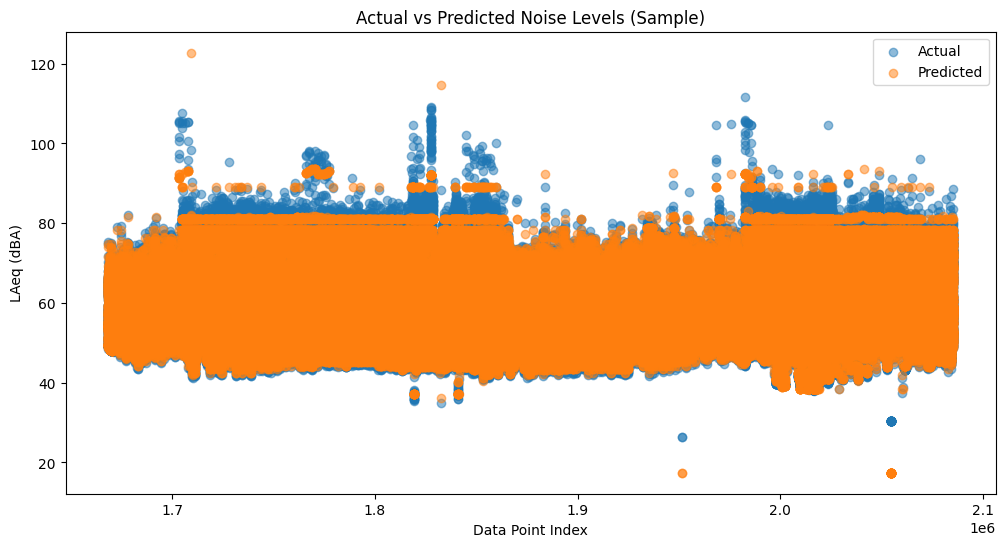


Feature Importance:
              feature  importance
3       noise_lag_1hr        2783
0                hour         609
6         loc_Dilshad         543
11    loc_mandir_marg         323
10            loc_ito         220
9            loc_isbt         167
8     loc_civil_lines         149
12           loc_nsit         116
1         day_of_week          89
5          loc_CPCBHQ          88
13        loc_punjabi          77
7   loc_centralschool          56
4             loc_COE           0
2          is_weekend           0


In [4]:
# --- MODEL TRAINING ---
# 1. Define your features (X) and target (y)
features = [
    'hour', 'day_of_week', 'is_weekend', 'noise_lag_1hr',
    # Add the one-hot encoded location columns
] + [col for col in df.columns if 'loc_' in col]

X = df[features]
y = df['LAeq'] # Corrected target column name

# 2. Split the data based on time (e.g., use the last 20% of data for testing)
split_point = int(len(df) * 0.8)
X_train, X_test = X[:split_point], X[split_point:]
y_train, y_test = y[:split_point], y[split_point:]

# 3. Initialize and train the LightGBM Regressor model with GPU support
# Ensure you have installed lightgbm with GPU support (e.g., pip install lightgbm --install-option=--gpu)
# In Colab with a GPU runtime, the default lightgbm might already use the GPU if available.
# We explicitly set device='gpu' to ensure it attempts to use the GPU.
import lightgbm as lgb

print("\nTraining the LightGBM model with GPU support...")
lgb_model = lgb.LGBMRegressor(objective='regression_l1', # MAE objective
                              n_estimators=500, # Increased estimators for potentially better accuracy
                              learning_rate=0.05,
                              num_leaves=31,
                              max_depth=10,
                              random_state=42,
                              n_jobs=-1, # Use all CPU threads for data loading/preprocessing
                              device='gpu', # Explicitly tell LightGBM to use the GPU
                              gpu_platform_id=0, # Usually 0 for the first GPU
                              gpu_device_id=0 # Usually 0 for the first GPU
                             )

lgb_model.fit(X_train, y_train,
              eval_set=[(X_test, y_test)], # Evaluate on test set during training
              eval_metric='mae', # Use MAE as evaluation metric
              callbacks=[lgb.early_stopping(10, verbose=False)]) # Stop if MAE doesn't improve for 10 rounds

print("Model training complete!")

# 4. Make predictions on the test set
predictions = lgb_model.predict(X_test)

# 5. Evaluate the model
mae = mean_absolute_error(y_test, predictions)
print(f"\nModel Evaluation (Mean Absolute Error): {mae:.2f} dBA")

# 6. (Optional) Plot actual vs predicted values for a sample
plt.figure(figsize=(12, 6))
plt.scatter(y_test.index, y_test, alpha=0.5, label='Actual')
plt.scatter(y_test.index, predictions, alpha=0.5, label='Predicted')
plt.title('Actual vs Predicted Noise Levels (Sample)')
plt.xlabel('Data Point Index')
plt.ylabel('LAeq (dBA)')
plt.legend()
plt.show()

# 7. (Optional) Feature Importance
print("\nFeature Importance:")
importance = pd.DataFrame({'feature': features, 'importance': lgb_model.feature_importances_})
print(importance.sort_values('importance', ascending=False))


Model Evaluation - Mean Absolute Error (MAE): 1.33 dBA
This means, on average, the model's prediction is off by about 1.33 dBA.


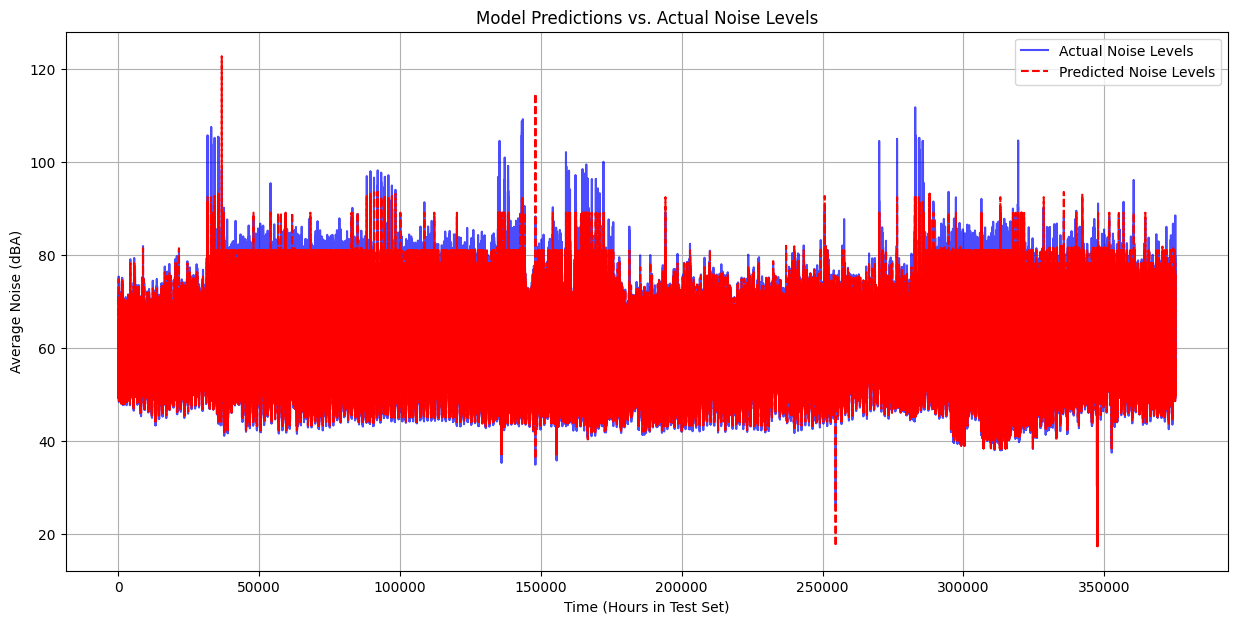

In [5]:
# --- MODEL EVALUATION ---
# 1. Calculate the Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, predictions)
print(f"\nModel Evaluation - Mean Absolute Error (MAE): {mae:.2f} dBA")
print("This means, on average, the model's prediction is off by about", f"{mae:.2f} dBA.")

# 2. Visualize Predictions vs. Actuals
plt.figure(figsize=(15, 7))
plt.plot(y_test.values, label='Actual Noise Levels', color='blue', alpha=0.7)
plt.plot(predictions, label='Predicted Noise Levels', color='red', linestyle='--')
plt.title('Model Predictions vs. Actual Noise Levels')
plt.xlabel('Time (Hours in Test Set)')
plt.ylabel('Average Noise (dBA)')
plt.legend()
plt.grid(True)
plt.savefig('/content/drive/My Drive/EST_Project/Visualizations/model_predictions.png')
plt.show()


Most Important Features for Predicting Noise:
            feature  importance
3     noise_lag_1hr        2783
0              hour         609
6       loc_Dilshad         543
11  loc_mandir_marg         323
10          loc_ito         220
9          loc_isbt         167
8   loc_civil_lines         149
12         loc_nsit         116
1       day_of_week          89
5        loc_CPCBHQ          88


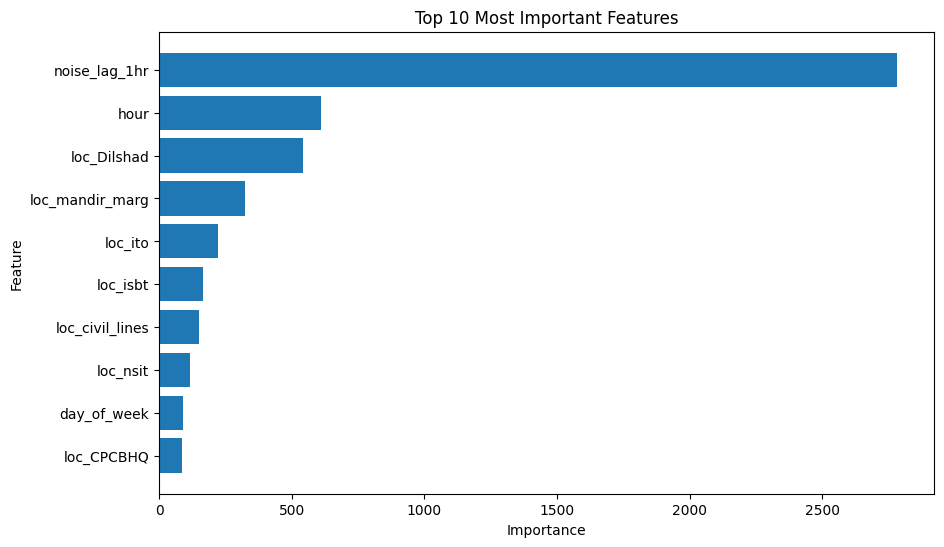

In [6]:
# --- INTERPRETING RESULTS ---
# 1. Get Feature Importances
# Use the correct model variable name (lgb_model)
importances = lgb_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': features,
    'importance': importances
}).sort_values('importance', ascending=False)

print("\nMost Important Features for Predicting Noise:")
print(feature_importance_df.head(10))

# 2. Plot Feature Importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['feature'].head(10), feature_importance_df['importance'].head(10))
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Most Important Features')
plt.gca().invert_yaxis()
plt.savefig('/content/drive/My Drive/EST_Project/feature_importance.png')
plt.show()

In [7]:
import pandas as pd
import numpy as np
import plotly.express as px
import os

# Define location coordinates again to ensure they are available in this cell's scope
location_coords = {
    'nsit': (28.609, 77.035),        # NSIT Dwarka
    'centralschool': (28.56, 77.23), # Kendriya Vidyalaya, Andrews Ganj (assumed)
    'ito': (28.631, 77.248),          # ITO Crossing
    'isbt': (28.646, 77.316),          # ISBT Anand Vihar
    'punjabi': (28.669, 77.125),      # Punjabi Bagh
    'mandir_marg': (28.628, 77.203),  # Mandir Marg
    'civil_lines': (28.678, 77.222),  # Civil Lines
    'CPCBHQ': (28.639, 77.303),      # CPCB Headquarter, East Arjun Nagar
    'Dilshad': (28.685, 77.318),       # Dilshad Garden
    'COE': (28.7433, 77.1169)         # College Of Engineering
}

# Ensure the features list is defined (it should be from the training cell, but good to be explicit)
features = [
    'hour', 'day_of_week', 'is_weekend', 'noise_lag_1hr',
] + [f'loc_{loc}' for loc in location_coords.keys()] # Recreate based on locations

# --- 1. PREPARE THE "FUTURE" DATA FOR PREDICTION ---

# Get the last known timestamp from your historical data
last_timestamp = df['DateTime'].max() # Use correct column name

# Create a list of all unique locations from your one-hot encoded columns in the *original* data
# Use the keys from the location_coords dictionary as the definitive list of locations
locations = list(location_coords.keys())
future_df_list = []

# For each location, create 24 hours of future timestamps
for location in locations:
    # Get the last known noise value for this specific location to use as our starting lag
    # Filter df for the specific location (using one-hot encoded column) and get the last LAeq
    last_known_noise_series = df[df[f'loc_{location}'] == 1]['LAeq']
    if not last_known_noise_series.empty:
         last_known_noise = last_known_noise_series.iloc[-1]
    else:
         last_known_noise = df['LAeq'].mean() # Use overall mean if no data for this location

    future_timestamps = pd.to_datetime([last_timestamp + pd.Timedelta(hours=i) for i in range(1, 25)])

    temp_df = pd.DataFrame({
        'DateTime': future_timestamps, # Use correct column name
        'Location': location,          # Use correct column name
        'noise_lag_1hr': last_known_noise # Use the last known value as the lag for the first prediction
                                          # A more advanced approach would iteratively predict and use the prediction as the next lag
    })
    future_df_list.append(temp_df)

# Combine into a single future dataframe
future_df = pd.concat(future_df_list)

# --- 2. ENGINEER FEATURES FOR THE FUTURE DATA ---
# It's crucial that these features match the ones used for training
future_df['hour'] = future_df['DateTime'].dt.hour # Use correct column name
future_df['day_of_week'] = future_df['DateTime'].dt.dayofweek # Use correct column name
future_df['is_weekend'] = future_df['day_of_week'].isin([5, 6]).astype(int)
future_df = pd.get_dummies(future_df, columns=['Location'], prefix='loc') # Use correct column name

# Ensure all location columns from the training set are present
# This handles cases where a location might not appear in the future_df if its last timestamp was much earlier
for col in [f'loc_{loc}' for loc in location_coords.keys()]:
    if col not in future_df.columns:
        future_df[col] = 0

# Reorder columns to match the model's training format
# Ensure 'noise_lag_1hr' is included in the future_df before selecting features
future_df = future_df[features]

# --- 3. MAKE PREDICTIONS ON THE FUTURE DATA ---
# Use the correct model variable name (lgb_model)
future_predictions = lgb_model.predict(future_df)
future_df['predicted_noise_dba'] = future_predictions

# --- 4. CREATE THE VISUAL RESULT: A PREDICTIVE MAP ---
# We need to aggregate the 24-hour forecast into a single average per location
# First, extract the location from the one-hot encoded columns
def get_location_from_one_hot(row, location_cols):
    for col in location_cols:
        if row[col] == 1:
            return col.replace('loc_', '')
    return None

location_cols = [col for col in future_df.columns if 'loc_' in col]
future_df['location_name'] = future_df.apply(lambda row: get_location_from_one_hot(row, location_cols), axis=1)

# Aggregate predictions by location
forecast_summary = future_df.groupby('location_name')['predicted_noise_dba'].mean().reset_index()

# Add coordinates back for mapping (using the 'location_coords' dictionary)
forecast_summary['latitude'] = forecast_summary['location_name'].map(lambda loc: location_coords.get(loc, (None, None))[0])
forecast_summary['longitude'] = forecast_summary['location_name'].map(lambda loc: location_coords.get(loc, (None, None))[1])

# Drop locations that might not have had coordinates defined
forecast_summary.dropna(subset=['latitude', 'longitude'], inplace=True)

# Create the final map
output_path_map = "/content/drive/My Drive/EST_Project/Visualizations/predictive_hotspot_map.png" # Corrected path
fig_predict_map = px.scatter_mapbox(forecast_summary,
                                  lat='latitude',
                                  lon='longitude',
                                  size='predicted_noise_dba',
                                  color='predicted_noise_dba',
                                  hover_name='location_name',
                                  color_continuous_scale=px.colors.sequential.YlOrRd,
                                  mapbox_style="open-street-map", # Changed map style to Open Street Map
                                  zoom=9,
                                  title="<b>Predicted Average Noise Hotspots for the Next 24 Hours</b>",
                                  labels={'predicted_noise_dba': 'Predicted Avg. Noise (dBA)'},
                                  size_max=30, # Increase marker size for better visibility
                                  center={'lat': 28.6139, 'lon': 77.2090}) # Center on Delhi

fig_predict_map.update_layout(title_x=0.5)

try:
    fig_predict_map.write_image(output_path_map)
    print(f"✅ Predictive hotspot map saved as PNG: {output_path_map}")
except Exception as e:
    print(f"⚠️ Could not save PNG: {e}")
    output_path_html = output_path_map.replace('.png', '.html')
    fig_predict_map.write_html(output_path_html)
    print(f"✅ Predictive hotspot map saved as HTML: {output_path_html}")


fig_predict_map.show()

⚠️ Could not save PNG: 
Image export using the "kaleido" engine requires the kaleido package,
which can be installed using pip:
    $ pip install -U kaleido

✅ Predictive hotspot map saved as HTML: /content/drive/My Drive/EST_Project/Visualizations/predictive_hotspot_map.html


In [9]:
import joblib
import lightgbm as lgb
import os # Import the os module

# Assuming 'lgb_model' is your trained LightGBM model
# Assuming 'X_train' is the DataFrame used for training

# Define the target directory in Google Drive
output_dir = '/content/drive/My Drive/EST_Project/ml_model/'

# Create the directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# 1. Save the model object to the specified directory
model_path = os.path.join(output_dir, 'lgb_model.pkl')
joblib.dump(lgb_model, model_path)

# 2. Save the list of feature columns to the specified directory
# This is crucial to ensure the order and names are the same for prediction
model_columns = X_train.columns.tolist()
columns_path = os.path.join(output_dir, 'model_columns.pkl')
joblib.dump(model_columns, columns_path)

print(f"Model and columns saved successfully to: {output_dir}")

Model and columns saved successfully to: /content/drive/My Drive/EST_Project/ml_model/
